In [1]:
import sqlite3
import matplotlib.pyplot as plt
from matplotlib import font_manager, rc



### 윈도우 한글 폰트 설정 (예: 맑은 고딕)

In [2]:
font_path = "C:/Windows/Fonts/malgun.ttf"
font_name = font_manager.FontProperties(fname=font_path).get_name()
rc('font', family=font_name)

### DB 연결함수

In [3]:
DB_Name = '학교식당 조사.db'


def connect_db():
    conn = sqlite3.connect(DB_Name)
    cur = conn.cursor()
    return conn, cur

def create_table():
    conn, cur = connect_db()
    cur.execute(
        'CREATE TABLE IF NOT EXISTS restaurants '
        '(id INTEGER PRIMARY KEY AUTOINCREMENT, '
        'name TEXT NOT NULL, '
        'score REAL NOT NULL CHECK(score >= 1 AND score <= 5))')

    conn.commit()
    conn.close()

### 식당 입력 구현

In [4]:
def insert_restaurant():
    name = input("맛집 이름을 입력하세요: ")
    while True:
        try:
            score = float(input("평점 (1.0~5.0) 입력하세요: "))
            if 1 <= score <= 5:
                score = round(score, 1)
                break
            else:
                print("1 이상 5 이하 숫자를 입력하세요.")
        except:
            print("숫자로 입력해주세요.")

    conn, cur = connect_db()
    cur.execute('INSERT INTO restaurants (name, score) VALUES (?, ?)', (name, score))
    conn.commit()
    conn.close()
    print("등록 완료!")


In [5]:
def list_restaurants():
    conn, cur = connect_db()
    cur.execute('SELECT * FROM restaurants')
    rows = cur.fetchall()
    conn.close()

    if not rows:
        print("기록된 맛집이 없습니다.")
        return

    print("ID\t맛집 이름\t평점")
    print("-" * 30)
    for r in rows:
        print(f"{r[0]}\t{r[1]}\t{r[2]}")


### 식당 목록 갱신

In [6]:
def update_restaurant():
    list_restaurants()
    try:
        rid = int(input("수정할 맛집 ID를 입력하세요: "))
    except:
        print("숫자를 입력하세요.")
        return

    conn, cur = connect_db()
    cur.execute('SELECT * FROM restaurants WHERE id = ?', (rid,))
    row = cur.fetchone()
    if not row:
        print("해당 ID가 없습니다.")
        conn.close()
        return

    name = input(f"새 이름 입력 (현재: {row[1]}) [엔터 시 유지]: ")
    if name.strip() == '':
        name = row[1]

    while True:
        score_input = input(f"새 평점 입력 (1.0~5.0) (현재: {row[2]}) [엔터 시 유지]: ")
        if score_input.strip() == '':
            score = row[2]
            break
        try:
            score = float(score_input)
            if 1 <= score <= 5:
                score = round(score, 1)
                break
            else:
                print("1 이상 5 이하 숫자를 입력하세요.")
        except:
            print("숫자로 입력해주세요.")

    cur.execute('UPDATE restaurants SET name = ?, score = ? WHERE id = ?', (name, score, rid))
    conn.commit()
    conn.close()
    print("수정 완료!")

### 식당 데이터 삭제

In [7]:
def delete_restaurant():
    list_restaurants()
    try:
        rid = int(input("삭제할 맛집 ID를 입력하세요: "))
    except:
        print("숫자를 입력하세요.")
        return

    conn, cur = connect_db()
    cur.execute('SELECT * FROM restaurants WHERE id = ?', (rid,))
    row = cur.fetchone()
    if not row:
        print("해당 ID가 없습니다.")
        conn.close()
        return

    confirm = input(f"{row[1]}을(를) 삭제할까요? (y/n): ").lower()
    if confirm == 'y':
        cur.execute('DELETE FROM restaurants WHERE id = ?', (rid,))
        conn.commit()
        print("삭제 완료!")
    else:
        print("삭제 취소.")
    conn.close()

### 평점 분포 히스토그램 구현

In [8]:
def visualize_scores_boxplot():
    conn, cur = connect_db()
    cur.execute('SELECT name, score FROM restaurants')
    data = cur.fetchall()
    conn.close()

    if not data:
        print("평점 데이터가 없습니다.")
        return

    # 식당 이름별 평점 리스트 묶기
    scores_by_name = {}
    for name, score in data:
        scores_by_name.setdefault(name, []).append(score)

    names = list(scores_by_name.keys())
    scores = list(scores_by_name.values())

    plt.figure(figsize=(10, 6))
    plt.boxplot(scores, labels=names)
    plt.title('식당별 평점 분포 (박스플롯)')
    plt.xlabel('식당 이름')
    plt.ylabel('평점')
    plt.xticks(rotation=45, ha='right')
    plt.ylim(0, 5.5)
    plt.tight_layout()
    plt.show()

### 식당별 평균 평점 막대그래프

In [9]:
def visualize_avg_score_per_restaurant():
    """식당별 평균 평점 + 투표 개수 표시 막대그래프"""

    conn, cur = connect_db()
    cur.execute('SELECT name, AVG(score), COUNT(score) FROM restaurants GROUP BY name')
    data = cur.fetchall()
    conn.close()

    if not data:
        print("등록된 맛집이 없습니다.")
        return

    names = [row[0] for row in data]
    avg_scores = [row[1] for row in data]
    counts = [row[2] for row in data]

    plt.figure(figsize=(10, 6))
    bars = plt.bar(names, avg_scores, color='skyblue')
    plt.title('식당별 평균 평점 및 투표 개수')
    plt.xlabel('식당 이름')
    plt.ylabel('평균 평점')
    plt.ylim(1, 5)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()

    # 각 막대 위에 투표 개수 표시
    for bar, count in zip(bars, counts):
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, height + 0.1, f'투표수: {count}', ha='center', va='bottom', fontsize=8)

    plt.show()

### 실행


1. 맛집 등록
2. 맛집 목록
3. 맛집 수정
4. 맛집 삭제
5. 평점 분포 시각화
6. 식당별 평균 평점 그래프
7. 종료


선택:  2


ID	맛집 이름	평점
------------------------------
1	안녕	5.0
2	안녕	3.0
3	안녕	2.0
4	우와	2.0

1. 맛집 등록
2. 맛집 목록
3. 맛집 수정
4. 맛집 삭제
5. 평점 분포 시각화
6. 식당별 평균 평점 그래프
7. 종료


선택:  6


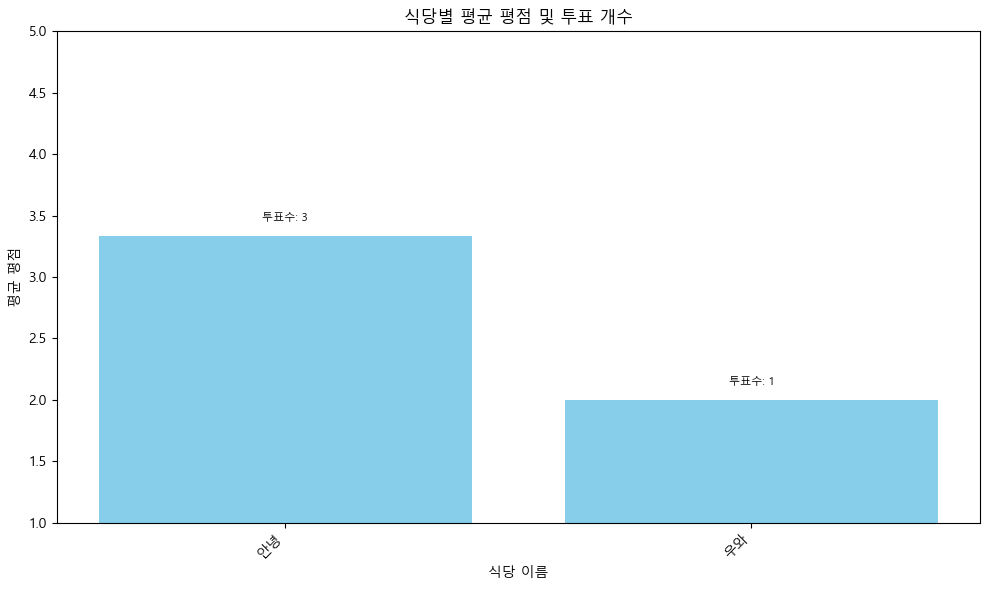


1. 맛집 등록
2. 맛집 목록
3. 맛집 수정
4. 맛집 삭제
5. 평점 분포 시각화
6. 식당별 평균 평점 그래프
7. 종료


선택:  5


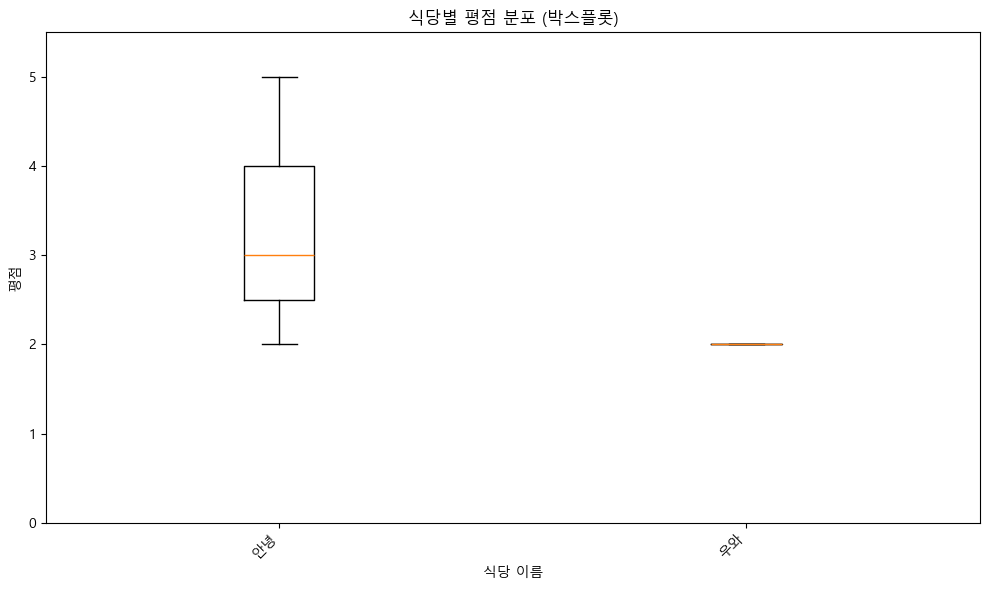


1. 맛집 등록
2. 맛집 목록
3. 맛집 수정
4. 맛집 삭제
5. 평점 분포 시각화
6. 식당별 평균 평점 그래프
7. 종료


In [ ]:
def main():
    create_table()
    while True:
        print("\n1. 맛집 등록")
        print("2. 맛집 목록")
        print("3. 맛집 수정")
        print("4. 맛집 삭제")
        print("5. 평점 분포 시각화")
        print("6. 식당별 평균 평점 그래프")
        print("7. 종료")
        choice = input("선택: ")

        if choice == '1':
            insert_restaurant()
        elif choice == '2':
            list_restaurants()
        elif choice == '3':
            update_restaurant()
        elif choice == '4':
            delete_restaurant()
        elif choice == '5':
            visualize_scores_boxplot()
        elif choice == '6':
            visualize_avg_score_per_restaurant()
        elif choice == '7':
            print("종료합니다.")
            break
        else:
            print("잘못된 입력입니다.")


if __name__ == "__main__":
    main()


In [ ]:
import sqlite3
import matplotlib.pyplot as plt
from matplotlib import font_manager, rc

# 윈도우 한글 폰트 설정 (예: 맑은 고딕)
font_path = "C:/Windows/Fonts/malgun.ttf"
font_name = font_manager.FontProperties(fname=font_path).get_name()
rc('font', family=font_name)


DB_Name = '학교식당 조사.db'


def connect_db():
    conn = sqlite3.connect(DB_Name)
    cur = conn.cursor()
    return conn, cur


def create_table():
    conn, cur = connect_db()
    cur.execute(
        'CREATE TABLE IF NOT EXISTS restaurants '
        '(id INTEGER PRIMARY KEY AUTOINCREMENT, '
        'name TEXT NOT NULL, '
        'score REAL NOT NULL CHECK(score >= 1 AND score <= 5))')

    conn.commit()
    conn.close()


# (생략: insert_restaurant, list_restaurants, update_restaurant, delete_restaurant 함수는 그대로 유지)


def visualize_score_distribution():
    """평점 분포 히스토그램 (기존 함수 유지)"""
    conn, cur = connect_db()
    cur.execute('SELECT score FROM restaurants')
    scores = [row[0] for row in cur.fetchall()]
    conn.close()

    if not scores:
        print("평점 데이터가 없습니다.")
        return

    plt.hist(scores, bins=[0.5 + 0.1 * i for i in range(46)], edgecolor='black')
    plt.title('맛집 평점 분포')
    plt.xlabel('평점')
    plt.ylabel('갯수')
    plt.show()


def visualize_avg_score_per_restaurant():
    """식당별 평균 평점 막대그래프 + 한글 깨짐 방지"""

    conn, cur = connect_db()
    cur.execute('SELECT name, AVG(score) FROM restaurants GROUP BY name')
    data = cur.fetchall()
    conn.close()

    if not data:
        print("등록된 맛집이 없습니다.")
        return

    names = [row[0] for row in data]
    avg_scores = [row[1] for row in data]

    plt.figure(figsize=(10, 6))
    plt.bar(names, avg_scores, color='skyblue')
    plt.title('식당별 평균 평점')
    plt.xlabel('식당 이름')
    plt.ylabel('평균 평점')
    plt.ylim(1, 5)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()

    # 한글 깨짐 방지 (rc('font', family=font_name) 이미 선언했으니 plt에서 폰트 재설정 불필요)
    plt.show()


def main():
    create_table()
    while True:
        print("\n1. 맛집 등록")
        print("2. 맛집 목록")
        print("3. 맛집 수정")
        print("4. 맛집 삭제")
        print("5. 평점 분포 시각화")
        print("6. 식당별 평균 평점 그래프")
        print("7. 종료")
        choice = input("선택: ")

        if choice == '1':
            insert_restaurant()
        elif choice == '2':
            list_restaurants()
        elif choice == '3':
            update_restaurant()
        elif choice == '4':
            delete_restaurant()
        elif choice == '5':
            visualize_score_distribution()
        elif choice == '6':
            visualize_avg_score_per_restaurant()
        elif choice == '7':
            print("종료합니다.")
            break
        else:
            print("잘못된 입력입니다.")


if __name__ == "__main__":
    main()
